In [111]:
import librosa
import os
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct
from librosa.feature import mfcc
from IPython.display import Audio
import pandas as pd
import time
import soundfile as sf
import random
from librosa.feature import delta

In [33]:
audiopath=r"C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac"

In [37]:
def process_audio_file(file_path, target_sr=8000, silence_threshold=20):
    # Load the audio file at its original sample rate
    signal, original_sr = librosa.load(file_path, sr=None)
    
    # Downsample the audio to reduce the size
    signal_resampled = librosa.resample(signal, orig_sr=original_sr, target_sr=target_sr)
    
    # Trim silence from the beginning and end of the signal
    trimmed_signal, _ = librosa.effects.trim(signal_resampled, top_db=silence_threshold)
    
    # Save the processed file as a downsampled version
    output_file = file_path.replace('.flac', f'_processed_{target_sr}.flac')
    sf.write(output_file, trimmed_signal, target_sr)
    
    return output_file


def process_dataset(audiopath, target_sr=8000, num_samples=5000):
    # Get all audio files from the directory
    all_files = [os.path.join(audiopath, f) for f in os.listdir(audiopath) if f.endswith('.flac')]
    
    # Check if there are enough files and select the required number
    if len(all_files) < num_samples:
        print(f"Only {len(all_files)} files available. Processing all of them.")
        num_samples = len(all_files)
    
    # Subsample the dataset
    selected_files = random.sample(all_files, num_samples)
    
    # Process each selected file
    processed_files = []
    for file in selected_files:
        processed_file = process_audio_file(file, target_sr=target_sr)
        processed_files.append(processed_file)
        print(f"Processed and saved: {processed_file}")

    return processed_files

processed_files = process_dataset(audiopath, target_sr=8000, num_samples=5000)




Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_9171237_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_6528766_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_3643694_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_6765931_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_2450253_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_8565326_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_7706323_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_4221275_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\D

Playing: LA_E_6528766_processed_8000.flac


Playing: LA_E_3643694_processed_8000.flac


Finished playing selected audio files.


Playing: LA_E_9171237_processed_8000.flac


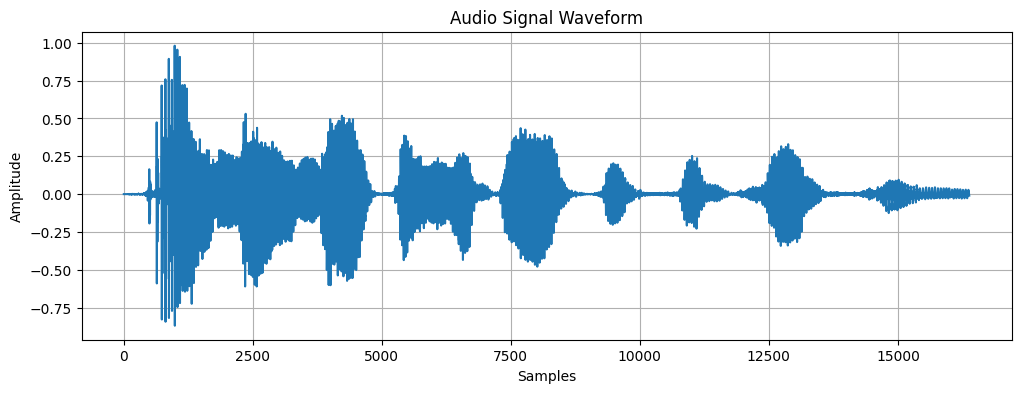

Playing: LA_E_6528766_processed_8000.flac


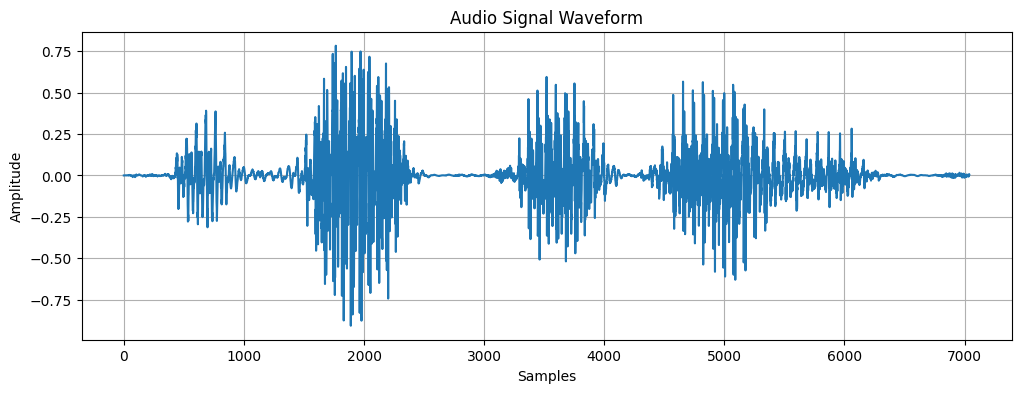

Playing: LA_E_3643694_processed_8000.flac


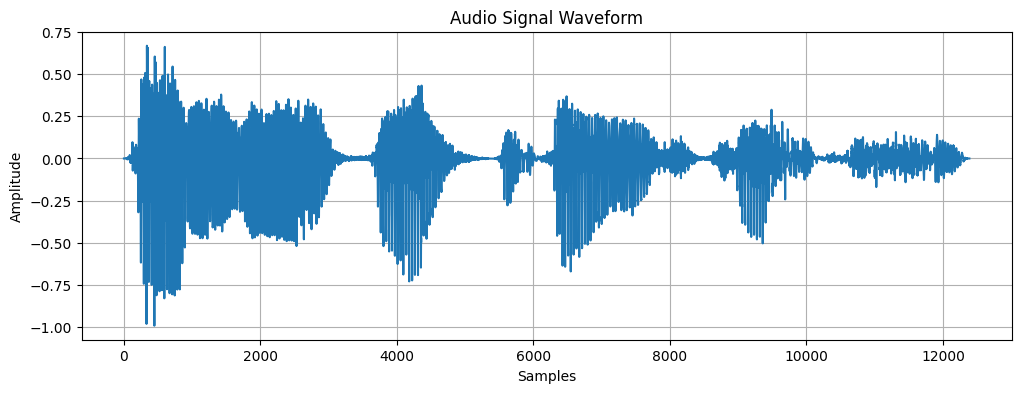

Finished playing selected audio files.


In [40]:
def load_and_play_audio(file_path):
    # Load the audio file using librosa
    signal, sr = librosa.load(file_path, sr=None)
    
    # Display the file name and play the audio
    print(f"Playing: {os.path.basename(file_path)}")
    plot_audio_waveform(signal, sr)
    display(Audio(data=signal, rate=sr))  # 'display' is used to play the audio
    time.sleep(3)# Limit the number of files to play for checking
files_to_play = processed_files[:3]  # Only play the first 3 processed files

# Play a few samples for checking
for file_path in files_to_play:
    load_and_play_audio(file_path)

print("Finished playing selected audio files.")


def plot_audio_waveform(signal, sr):
    """Plots the waveform of the audio signal."""
    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.title('Audio Signal Waveform')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()


Sample Rate: 16000 Hz
Processed Signal Length: 24576 samples
Processed Signal (first 10 samples): [ 1.0126903e-04  8.9583475e-05  2.8102442e-05  1.6025745e-04
  2.6320250e-04  5.8856344e-06 -4.1914004e-04 -4.6897982e-04
 -5.6649485e-05  2.5419245e-04]


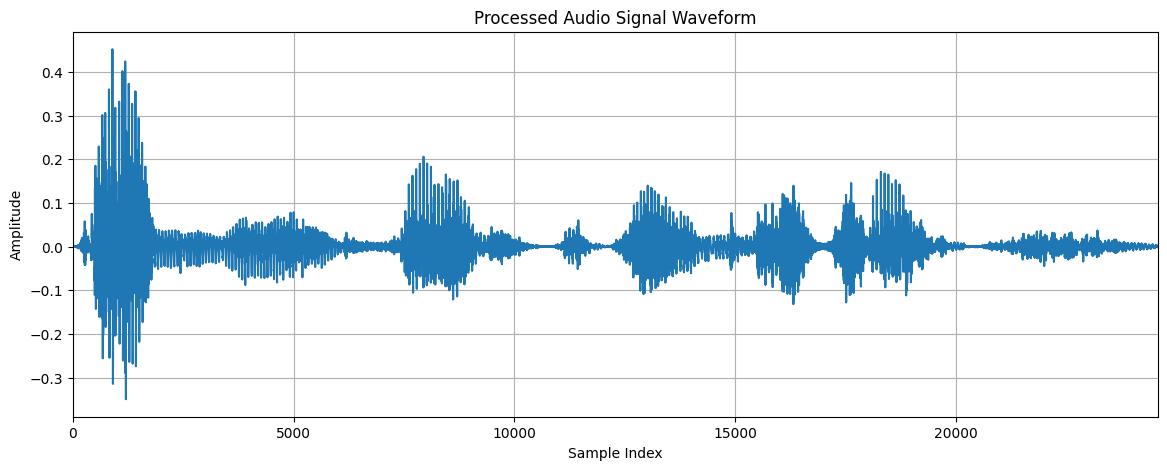

In [51]:
def spectral_subtraction(signal, noise_estimation_factor=0.1):
    """Apply spectral subtraction for noise reduction."""
    # Compute the Short-Time Fourier Transform (STFT)
    stft = librosa.stft(signal)
    
    # Compute magnitude and phase
    magnitude, phase = np.abs(stft), np.angle(stft)
    
    # Estimate noise by taking the average magnitude spectrum
    noise_magnitude = np.mean(magnitude, axis=1, keepdims=True) * noise_estimation_factor
    
    # Subtract noise from magnitude
    magnitude_clean = np.maximum(magnitude - noise_magnitude, 0)
    
    # Reconstruct the signal from cleaned magnitude and original phase
    cleaned_stft = magnitude_clean * np.exp(1j * phase)
    cleaned_signal = librosa.istft(cleaned_stft)
    
    return cleaned_signal


def preprocess_audio(file_path, sr=16000):
    """Preprocess audio file by normalizing, applying a pre-emphasis filter, and removing silence."""
    # Load audio file
    signal, sr = librosa.load(file_path, sr=sr)
    
    # Normalize the audio signal
    signal = signal / np.max(np.abs(signal))

    # Pre-emphasis filter
    pre_emphasis = 0.97
    signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    # Remove silence
    signal, _ = librosa.effects.trim(signal)

    # Apply spectral subtraction for noise reduction
    cleaned_signal = spectral_subtraction(signal)

    # Print details about the processed audio
    print(f"Sample Rate: {sr} Hz")
    print(f"Processed Signal Length: {len(cleaned_signal)} samples")
    print(f"Processed Signal (first 10 samples): {cleaned_signal[:10]}")

    # Plot the processed audio signal waveform
    plt.figure(figsize=(14, 5))
    plt.plot(cleaned_signal)
    plt.title('Processed Audio Signal Waveform')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.xlim(0, len(cleaned_signal))
    plt.grid()
    plt.show()

    return cleaned_signal, sr

processed_signal, sample_rate = preprocess_audio(file_path)

MFCCs shape: (79, 20)
Delta shape: (79, 20)
Double Delta shape: (79, 20)


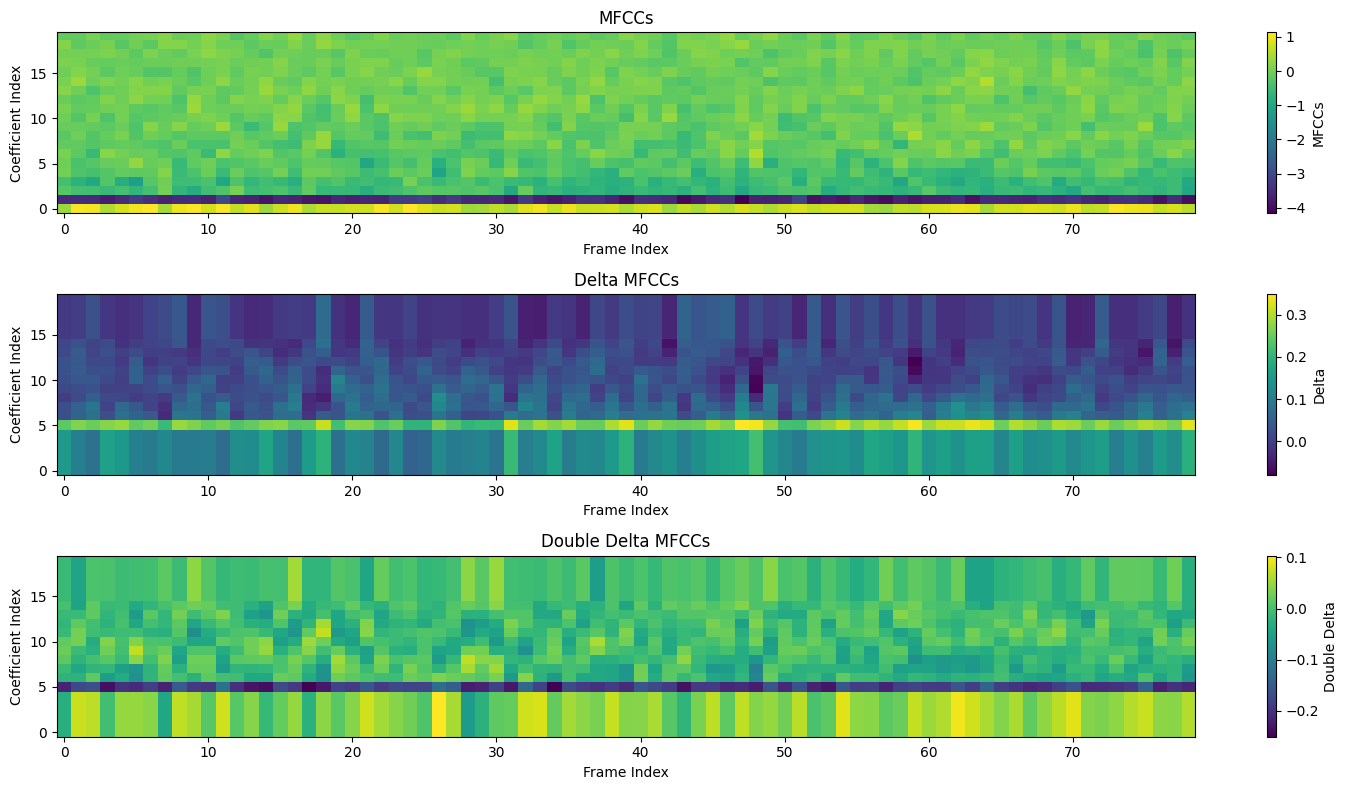

In [58]:
def extract_mfcc(speech, Fs, Window_Length, NFFT, No_Filter):
    
    # Pre-emphasis filter to enhance high frequencies
    speech = np.append(speech[0], speech[1:] - 0.97 * speech[:-1])
    
    # Framing and windowing
    frame_length_in_samples = int((Fs / 1000) * Window_Length)  # Convert window length to samples
    hop_length = frame_length_in_samples // 2  # Overlap of 50%
    
    # Frame the speech signal
    framedspeech = librosa.util.frame(speech, frame_length=frame_length_in_samples, hop_length=hop_length).T
    
    # Apply Hamming window to each frame
    w = np.hamming(frame_length_in_samples)
    y_framed = framedspeech * w
    
    # Compute the magnitude spectrum
    fr_all = np.abs(np.fft.fft(y_framed, NFFT))**2  # Magnitude squared
    
    # Keep only the first half of the spectrum
    fr_all = fr_all[:, :NFFT // 2 + 1]

    # Mel filter bank
    mel_filters = librosa.filters.mel(sr=Fs, n_fft=NFFT, n_mels=No_Filter, fmin=0, fmax=Fs // 2)
    
    # Apply the filter bank
    mel_spectrum = np.dot(fr_all, mel_filters.T)  # Apply the mel filter bank
    
    # Logarithmic scaling
    log_mel_spectrum = np.log10(mel_spectrum + np.finfo(float).eps)  # Avoid log(0)
    
    # Discrete Cosine Transform (DCT) to obtain MFCCs
    mfccs = dct(log_mel_spectrum, type=2, axis=1, norm='ortho')[:, :No_Filter]
    
    # Calculate delta and double delta
    delta = librosa.feature.delta(mfccs)  # First derivative
    double_delta = librosa.feature.delta(mfccs, order=2)  # Second derivative

    return mfccs, delta, double_delta

sr = 16000  # Sample rate
speech = np.random.randn(sr)  # 1 second of random noise

# Parameters for MFCC extraction
Window_Length = 25  # in milliseconds
NFFT = 512  # Number of FFT points
No_Filter = 20  # Number of Mel filter banks to use

# Extract MFCCs
mfccs, delta, double_delta = extract_mfcc(speech, sr, Window_Length, NFFT, No_Filter)

# Display the shapes of the extracted features
print(f'MFCCs shape: {mfccs.shape}')
print(f'Delta shape: {delta.shape}')
print(f'Double Delta shape: {double_delta.shape}')

def plot_features(mfccs, delta, double_delta):
    plt.figure(figsize=(15, 8))

    # Plot MFCCs
    plt.subplot(3, 1, 1)
    plt.imshow(mfccs.T, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='MFCCs')
    plt.title('MFCCs')
    plt.xlabel('Frame Index')
    plt.ylabel('Coefficient Index')

    # Plot Delta
    plt.subplot(3, 1, 2)
    plt.imshow(delta.T, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Delta')
    plt.title('Delta MFCCs')
    plt.xlabel('Frame Index')
    plt.ylabel('Coefficient Index')

    # Plot Double Delta
    plt.subplot(3, 1, 3)
    plt.imshow(double_delta.T, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Double Delta')
    plt.title('Double Delta MFCCs')
    plt.xlabel('Frame Index')
    plt.ylabel('Coefficient Index')

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_features(mfccs, delta, double_delta)

In [60]:
def trimf(x, params):
    if len(params) != 3:
        raise ValueError("trimf requires params to be a list of 3 elements")
    a, b, c = params
    y = np.zeros_like(x)
    if a < b:
        index = (x > a) & (x < b)
        y[index] = (x[index] - a) / (b - a)
    if b < c:
        index = (x > b) & (x < c)
        y[index] = (c - x[index]) / (c - b)
    y[x == b] = 1.0
    return y

In [62]:
def deltas(features, N=3):
    """
    Compute the delta coefficients of the input features.
    N: Number of frames for the delta computation.
    """
    if len(features.shape) == 1:
        features = features[:, np.newaxis]  # Ensure features are 2D
    delta = np.zeros_like(features)
    for t in range(features.shape[0]):
        for i in range(features.shape[1]):
            if t < N:
                delta[t, i] = np.sum((np.arange(1, N + 1) * (features[min(t + N, features.shape[0] - 1), i] - features[t, i])))/N
            elif t >= features.shape[0] - N:
                delta[t, i] = np.sum((np.arange(1, N + 1) * (features[t, i] - features[max(t - N, 0), i])))/N
            else:
                delta[t, i] = np.sum((np.arange(1, N + 1) * (features[t + N, i] - features[t - N, i])))/(2 * N)
    return delta

In [108]:
def extract_lfcc(speech, Fs, Window_Length, NFFT, No_Filter):
    # Pre-emphasis
    speech = np.append(speech[0], speech[1:] - 0.97 * speech[:-1])
    
    # Framing and windowing
    frame_length_in_samples = int((Fs / 1000) * Window_Length)
    hop_length = frame_length_in_samples // 2
    framedspeech = librosa.util.frame(speech, frame_length=frame_length_in_samples, hop_length=hop_length).T
    w = np.hamming(frame_length_in_samples)
    y_framed = framedspeech * w
    
    # Frequency and filter bank
    f = (Fs / 2) * np.linspace(0, 1, NFFT // 2 + 1)
    filter_bandwidths = np.linspace(min(f), max(f), No_Filter + 2)
    fr_all = np.abs(np.fft.fft(y_framed, NFFT))**2
    fa_all = fr_all[:, :NFFT // 2 + 1]
    
    # Filter bank creation
    filterbank = np.zeros((NFFT // 2 + 1, No_Filter))
    for i in range(No_Filter):
        filterbank[:, i] = trimf(f, [filter_bandwidths[i], filter_bandwidths[i + 1], filter_bandwidths[i + 2]])
    
    filbanksum = np.dot(fa_all, filterbank)

    # Calculate static LFCC
    t = dct(np.log10(filbanksum + np.finfo(float).eps), type=2, axis=1, norm='ortho')[:, :No_Filter]
    stat = t.T
    
    # Calculate delta and double delta
    delta = deltas(stat, 3).T
    double_delta = deltas(delta, 3).T

    return stat, delta, double_delta
sr = 16000  # Sample rate
speech = np.random.randn(sr)  # 1 second of random noise

# Parameters for LFCC extraction
Window_Length = 25  # in milliseconds
NFFT = 512  # Number of FFT points
No_Filter = 20  # Number of Mel filter banks to use

# Extract LFCCs
stat, delta, double_delta = extract_lfcc(speech, sr, Window_Length, NFFT, No_Filter)
print("Static LFCC shape:", stat.shape)
print("Delta LFCC shape:", delta.shape)
print("Double Delta LFCC shape:", double_delta.shape)

print("Static LFCC (first 3 values):", stat[0:1000])
print("Delta LFCC (first 3 values):", delta[0:1000])
print("Double Delta LFCC (first 3 values):", double_delta[0:1000])


Static LFCC shape: (20, 79)
Delta LFCC shape: (79, 20)
Double Delta LFCC shape: (20, 79)
Static LFCC (first 3 values): [[ 1.51252000e+01  1.48351514e+01  1.42347762e+01 ...  1.48661460e+01
   1.47042047e+01  1.48650174e+01]
 [-1.86144146e+00 -2.24608457e+00 -2.04261095e+00 ... -2.03949141e+00
  -2.02212000e+00 -2.58491070e+00]
 [-9.16161762e-01 -1.09160027e+00 -1.09981504e+00 ... -1.39299124e+00
  -6.48205609e-01 -1.41555495e+00]
 ...
 [ 3.68909977e-03 -2.25706270e-02  5.48552535e-02 ...  2.84648662e-02
  -6.55625680e-02 -2.01457313e-01]
 [-2.31972108e-01 -2.97341604e-02  4.60190539e-02 ...  1.16871933e-02
  -8.57979338e-02  1.19864383e-01]
 [ 4.87181256e-02 -6.59447903e-02  1.44370743e-01 ...  1.01140875e-01
  -1.83123532e-01  9.07023409e-02]]
Delta LFCC (first 3 values): [[-3.13907594e+01  3.38141153e+00  1.52241442e+00 ...  3.48006348e-01
  -6.46051528e-01 -8.24185471e-02]
 [-3.07818742e+01  3.79141956e+00  1.72552440e+00 ...  1.48046417e-01
  -6.80853130e-02  1.53619668e-01]
 [-2.9

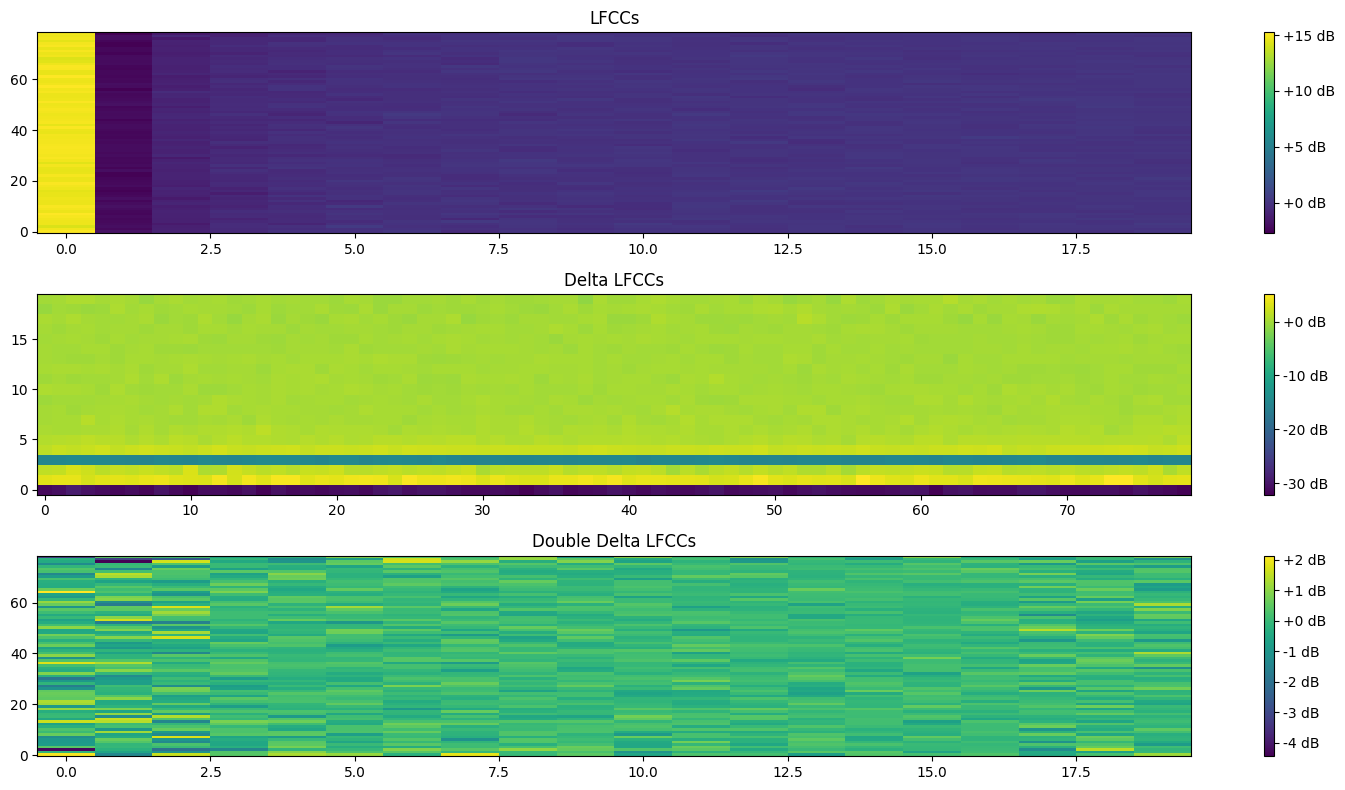

In [109]:
plt.figure(figsize=(15, 8))

# LFCCs
plt.subplot(3, 1, 1)
plt.imshow(stat.T, aspect='auto', origin='lower', interpolation='none')
plt.title('LFCCs')
plt.colorbar(format='%+2.0f dB')

# Delta LFCCs
plt.subplot(3, 1, 2)
plt.imshow(delta.T, aspect='auto', origin='lower', interpolation='none')
plt.title('Delta LFCCs')
plt.colorbar(format='%+2.0f dB')

# Double Delta LFCCs
plt.subplot(3, 1, 3)
plt.imshow(double_delta.T, aspect='auto', origin='lower', interpolation='none')
plt.title('Double Delta LFCCs')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

MFCCs shape: (20, 81)
Delta MFCC shape: (79, 20)
Double Delta MFCC shape: (20, 79)
MFCCs (first 3 values): [[ 4.17470136e+01  7.48480052e+01  6.19613545e+01 ...  7.16492050e+01
   5.77666877e+01  2.17753261e+01]
 [-2.12389875e+00 -3.66190069e+00 -1.65726246e+01 ... -3.72041818e+00
  -1.49184251e+01 -1.75807701e+00]
 [-8.10989695e+00 -2.95016030e+00 -7.55925471e-01 ... -1.66977052e-01
  -3.04663587e+00  1.82308533e+01]
 ...
 [ 4.12784385e+00 -5.32718940e+00 -4.28986450e+00 ...  1.48212068e+00
  -1.49193354e+00 -9.95069842e+00]
 [ 7.21152083e+00  4.23093389e+00  4.31494846e+00 ... -3.05072683e-01
   1.30027814e+00 -3.08204260e+00]
 [-2.76307892e+00  3.30650004e+00  1.61466165e+00 ...  3.55134868e+00
   1.74117696e-02 -5.12620685e+00]]
Delta MFCC (first 3 values): [[-3.13907594e+01  3.38141153e+00  1.52241442e+00 ...  3.48006348e-01
  -6.46051528e-01 -8.24185471e-02]
 [-3.07818742e+01  3.79141956e+00  1.72552440e+00 ...  1.48046417e-01
  -6.80853130e-02  1.53619668e-01]
 [-2.93321290e+01 

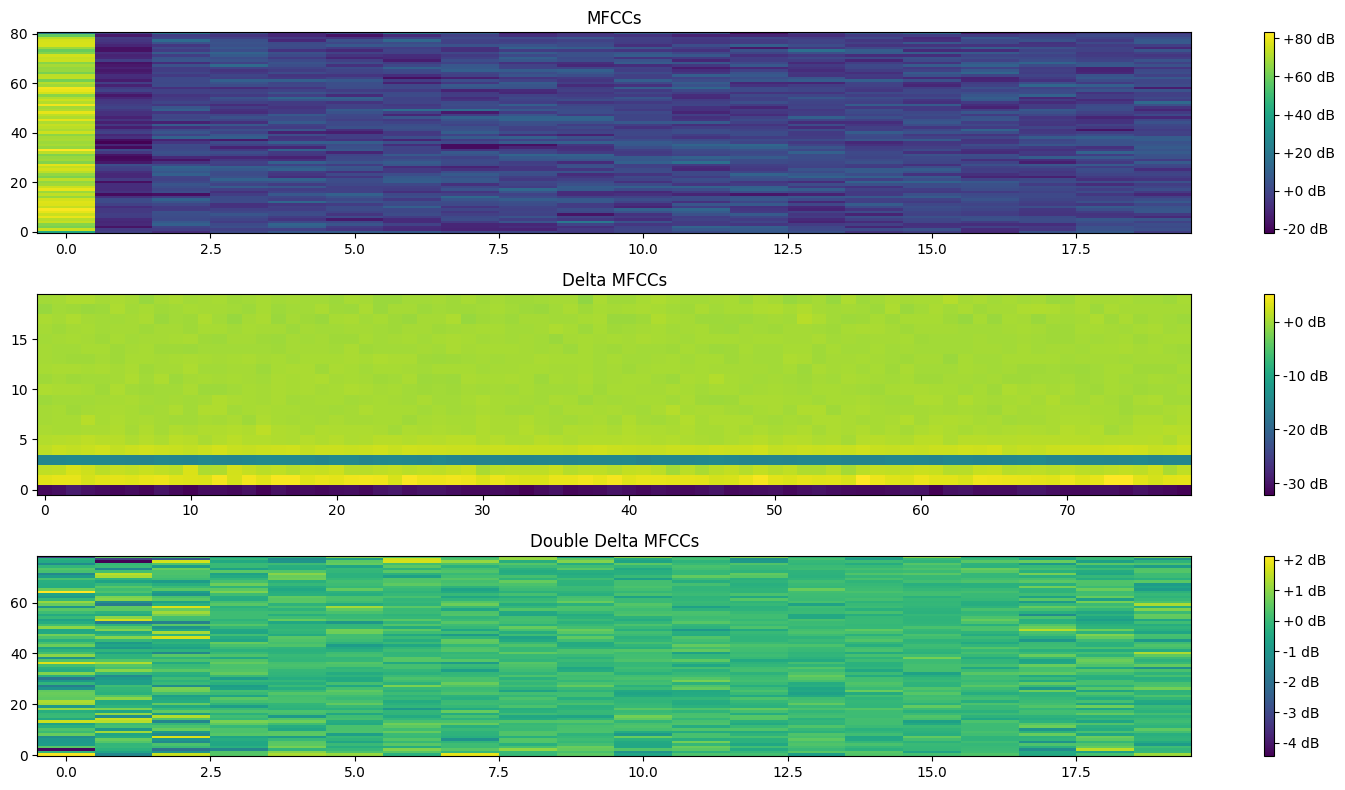

In [110]:
def extract_mfcc(speech, Fs, Window_Length, NFFT, No_Filter):
    # Pre-emphasis
    speech = np.append(speech[0], speech[1:] - 0.97 * speech[:-1])
    
    # Framing and windowing
    frame_length_in_samples = int((Fs / 1000) * Window_Length)
    hop_length = frame_length_in_samples // 2
    framedspeech = librosa.util.frame(speech, frame_length=frame_length_in_samples, hop_length=hop_length).T
    w = np.hamming(frame_length_in_samples)
    y_framed = framedspeech * w
    
    # Compute the magnitude spectrum
    fr_all = np.abs(np.fft.fft(y_framed, NFFT))**2
    
    # Keep only the first half of the spectrum
    fr_all = fr_all[:, :NFFT // 2 + 1]

    # Mel filter bank
    mel_filters = librosa.filters.mel(sr=Fs, n_fft=NFFT, n_mels=No_Filter, fmin=0, fmax=Fs // 2)
    
    # Apply the filter bank
    mel_spectrum = np.dot(fr_all, mel_filters.T)  # This should work now as dimensions align
    
    # Logarithm
    log_mel_spectrum = np.log10(mel_spectrum + np.finfo(float).eps)
    
    # Discrete Cosine Transform (DCT)
    mfccs = dct(log_mel_spectrum, type=2, axis=1, norm='ortho')[:, :No_Filter]
    
    # Calculate delta and double delta
    delta = librosa.feature.delta(mfccs)
    double_delta = librosa.feature.delta(mfccs, order=2)

    return mfccs, delta, double_delta

print("MFCCs shape:", mfccs.shape)  # Expecting (number_of_frames, No_Filter)
print("Delta MFCC shape:", delta.shape)  # Expecting (number_of_frames, No_Filter)
print("Double Delta MFCC shape:", double_delta.shape)  # Expecting (number_of_frames, No_Filter)

# Print the first few values of each output
print("MFCCs (first 3 values):", mfccs[0:1000])  
print("Delta MFCC (first 3 values):", delta[0:1000])  
print("Double Delta MFCC (first 3 values):", double_delta[0:1000])


plt.figure(figsize=(15, 8))

# MFCCs
plt.subplot(3, 1, 1)
plt.imshow(mfccs.T, aspect='auto', origin='lower', interpolation='none')
plt.title('MFCCs')
plt.colorbar(format='%+2.0f dB')

# Delta
plt.subplot(3, 1, 2)
plt.imshow(delta.T, aspect='auto', origin='lower', interpolation='none')
plt.title('Delta MFCCs')
plt.colorbar(format='%+2.0f dB')

# Double Delta
plt.subplot(3, 1, 3)
plt.imshow(double_delta.T, aspect='auto', origin='lower', interpolation='none')
plt.title('Double Delta MFCCs')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [130]:
def extract_features_from_directory(directory_path, Window_Length, NFFT, No_Filter):
    all_mfccs = []
    all_lfccs = []
    file_names = []

    # Loop through each file in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.wav'):  # Ensure you're only processing .wav files
            file_path = os.path.join(directory_path, filename)
            print(f'Processing {file_path}...')

            # Load the audio file
            speech, sr = librosa.load(file_path, sr=None)

            # Extract MFCCs
            mfccs, _, _ = extract_mfcc(speech, sr, Window_Length, NFFT, No_Filter)

            # Extract LFCCs
            lfccs, _, _ = extract_lfcc(speech, sr, Window_Length, NFFT, No_Filter)

            # Store the features
            all_mfccs.append(mfccs)
            all_lfccs.append(lfccs)
            file_names.append(filename)

    # Convert to DataFrames for easier handling
    mfcc_df = pd.DataFrame(all_mfccs)
    lfcc_df = pd.DataFrame(all_lfccs)

    # Optionally save the features to CSV
    mfcc_df.to_csv('mfcc_features.csv', index=False)
    lfcc_df.to_csv('lfcc_features.csv', index=False)

    return mfcc_df, lfcc_df, file_names

# Specify your directory path here

Window_Length = 25  # in milliseconds
NFFT = 512  # Number of FFT points
Window_Length = 1024
No_Filter = 20  # Number of Mel filter banks to use

# Extract features
mfccs, lfccs, filenames = extract_features_from_directory(audiopath, Window_Length, NFFT, No_Filter)

# print("MFCCs DataFrame shape:", mfccs.shape)
# print("LFCCs DataFrame shape:", lfccs.shape)

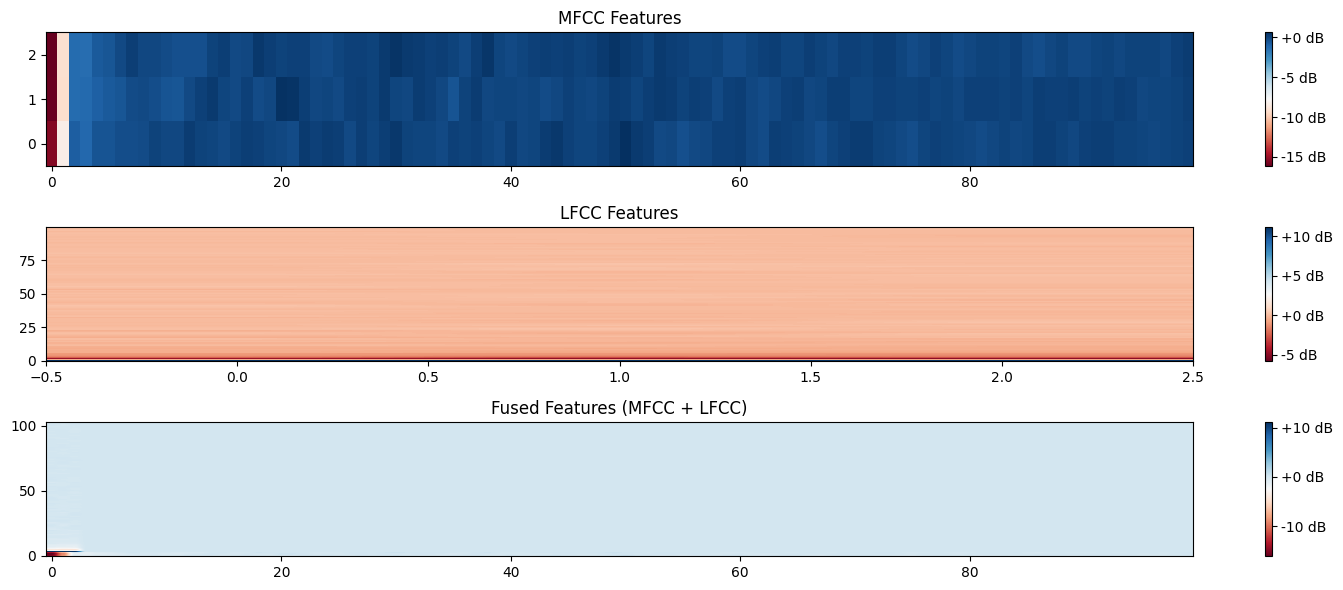

Combined features saved to combined_features.csv


In [128]:
signal = np.random.rand(5 * 22050)  # Simulated audio signal (5 seconds)
sr = 22050  # Sample rate
Window_Length = 2048  # Window length for STFT
NFFT = 2048  # Number of FFT points
No_Filter = 100
max_samples = 5000


def fuse_features(mfccs, lfccs):
    if mfccs.size == 0 or lfccs.size == 0:
        print("One of the features is empty. Cannot fuse.")
        return None, None

    # Get the number of frames for both MFCC and LFCC
    mfcc_frames = mfccs.shape[1]  # number of frames
    lfcc_frames = lfccs.shape[1]

    # Determine which one has fewer frames and pad accordingly
    if mfcc_frames < lfcc_frames:
        padding = np.zeros((mfccs.shape[0], lfcc_frames - mfcc_frames))  # Pad MFCCs
        mfccs = np.hstack([mfccs, padding])
    elif lfcc_frames < mfcc_frames:
        padding = np.zeros((lfccs.shape[0], mfcc_frames - lfcc_frames))  # Pad LFCCs
        lfccs = np.hstack([lfccs, padding])

    # Fuse features along the coefficient axis (vertical stacking)
    combined_features = np.concatenate((mfccs, lfccs), axis=0)

    # Create DataFrame and save to CSV
    combined_df = pd.DataFrame(combined_features.T)  # Transpose to match rows/columns
    csv_file_path = 'combined_features.csv'  # Change this path as needed
    combined_df.to_csv(csv_file_path, index=False)
    
    return combined_features, csv_file_path
    


def plot_features(mfccs, lfccs, fused_features):
    plt.figure(figsize=(15, 6))

    # Plot MFCCs
    plt.subplot(3, 1, 1)
    plt.imshow(mfccs, aspect='auto', origin='lower', cmap='RdBu')
    plt.title('MFCC Features')
    plt.colorbar(format='%+2.0f dB')

    # Plot LFCCs
    plt.subplot(3, 1, 2)
    plt.imshow(lfccs, aspect='auto', origin='lower', cmap='RdBu')
    plt.title('LFCC Features')
    plt.colorbar(format='%+2.0f dB')

    # Plot Fused Features
    plt.subplot(3, 1, 3)
    plt.imshow(fused_features, aspect='auto', origin='lower', cmap='RdBu')
    plt.title('Fused Features (MFCC + LFCC)')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

# Feature extraction and plotting
mfccs, _, _ = extract_mfcc(signal, sr, Window_Length, NFFT, No_Filter)
lfccs, _, _ = extract_lfcc(signal, sr, Window_Length, NFFT, No_Filter)

# Fuse MFCC and LFCC features
fused_features, csv_file_path = fuse_features(mfccs, lfccs)

if mfccs.size > 0 and lfccs.size > 0:
    fused_features, csv_file_path = fuse_features(mfccs, lfccs)

    # Plot the features
    plot_features(mfccs, lfccs, fused_features)

    print(f"Combined features saved to {csv_file_path}")
else:
    print("Feature extraction failed. No features to fuse or plot.")
